<a href="https://colab.research.google.com/github/pierreduke/DeepFake_Detection/blob/main/STEP4_CELEB_train_test_CNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Kết nối Google Colab với Drive và cài đặt các thư viện cần thiết**

In [ ]:
from google.colab import drive
drive._mount('/content/drive')

Mounted at /content/drive


In [ ]:
! pip install -U git+https://github.com/qubvel/efficientnet
! pip install tensorflow-addons

  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-h5cpfmwd
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-h5cpfmwd


**Giải nén tệp dữ liệu**

In [ ]:
# !unzip  /content/drive/MyDrive/DatasetFF_train.zip
!unzip  /content/drive/MyDrive/DatasetCELEB_train.zip

**1) Khai báo các thư viện sử dụng**

In [ ]:
import os
import keras.backend as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image_dataset_from_directory
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.models import load_model, Model, Sequential
from tensorflow.keras.layers import Input, Dense, Flatten, Dropout, InputSpec, Layer, BatchNormalization
from tensorflow.keras.layers import AveragePooling2D, AveragePooling1D, MaxPooling2D, MaxPooling1D
from tensorflow_addons.layers import SpatialPyramidPooling2D



> **1.1) Đối với DenseNet121 và Xception**



In [ ]:
# from tensorflow.keras.applications import Xception
# baseModel = Xception(weights="imagenet", include_top=False,
#                     input_tensor=Input(shape=(224,224,3)))
# headModel = baseModel.output
# headModel = SpatialPyramidPooling2D([1, 2, 4])(headModel)
# headModel = AveragePooling1D(pool_size=21)(headModel)
# headModel = Flatten(name="flatten")(headModel)
# headModel = Dense(512, activation="relu")(headModel)
# headModel = Dropout(0.5)(headModel)
# headModel = Dense(256, activation="relu")(headModel)
# headModel = Dense(2, activation="softmax")(headModel)
# model = Model(inputs=baseModel.input, outputs=headModel)
# model.summary()



> **1.2) Đối với EfficientNetB0 đến EfficientNetB2**



In [ ]:
from efficientnet.tfkeras import EfficientNetB2 #EfficientNetB0, EfficientNetB1, EfficientNetB2
efficient_net = EfficientNetB2(
    weights = 'imagenet',
    input_shape = (224, 224, 3),
    include_top = False,
)

model = Sequential()
model.add(efficient_net)
model.add(SpatialPyramidPooling2D([1, 2, 4]))
# model.add(MaxPooling1D(pool_size=21))
model.add(Flatten(name="flatten"))
# model.add(Dense(units = 512, activation = 'relu'))
# model.add(Dropout(0.5))
# model.add(Dense(units = 256, activation = 'relu'))
model.add(Dense(units = 2, activation = 'softmax'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b2 (Functional  (None, 7, 7, 1408)       7768562   
 )                                                               
                                                                 
 spatial_pyramid_pooling2d (  (None, 21, 1408)         0         
 SpatialPyramidPooling2D)                                        
                                                                 
 flatten (Flatten)           (None, 29568)             0         
                                                                 
 dense (Dense)               (None, 2)                 59138     
                                                                 
Total params: 7,827,700
Trainable params: 7,760,132
Non-trainable params: 67,568
_________________________________________________________________


In [ ]:
model.compile(optimizer = Adam(learning_rate=0.0001), loss='categorical_crossentropy', metrics=['accuracy'])

**2) Khởi tạo đường dẫn, checkpoint và callbacks**

In [ ]:
train_path = '/content/DatasetCELEB_train/train'
val_path = '/content/DatasetCELEB_train/val'

In [ ]:
checkpoint_filepath = '/content/drive/MyDrive/model_checkpoint/'
print('Creating Directory: ' + checkpoint_filepath)
os.makedirs(checkpoint_filepath, exist_ok=True)

Creating Directory: /content/drive/MyDrive/model_checkpoint/


In [ ]:
custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 10,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'SPP2_EfficientNetB2_CELEB.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

**3) ImageDataGenerator**

In [ ]:
train_datagen = ImageDataGenerator(
    rescale = 1/255,
    rotation_range = 10,
    width_shift_range = 0.1,
    height_shift_range = 0.1,
    shear_range = 0.2,
    zoom_range = 0.1,
    horizontal_flip = True,
    fill_mode = 'nearest'
)
train_generator = train_datagen.flow_from_directory(
    directory = train_path,
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

val_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)
val_generator = val_datagen.flow_from_directory(
    directory = val_path,
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = "categorical",
    batch_size = 32,
    shuffle = True
)

Found 77703 images belonging to 2 classes.
Found 19426 images belonging to 2 classes.


In [ ]:
len(train_generator)

2429

**4) Huấn luyện**

In [ ]:
num_epochs = 20

In [ ]:
H = model.fit(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = custom_callbacks
)
print(H.history)

Epoch 1/20
2429/2429 [==============================] - ETA: 0s - loss: 0.1727 - accuracy: 0.9267
Epoch 00001: val_loss improved from inf to 0.05199, saving model to /content/drive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2429/2429 [==============================] - 840s 338ms/step - loss: 0.1727 - accuracy: 0.9267 - val_loss: 0.0520 - val_accuracy: 0.9804
Epoch 2/20
2429/2429 [==============================] - ETA: 0s - loss: 0.0517 - accuracy: 0.9811
Epoch 00002: val_loss improved from 0.05199 to 0.03634, saving model to /content/drive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB.h5
2429/2429 [==============================] - 818s 337ms/step - loss: 0.0517 - accuracy: 0.9811 - val_loss: 0.0363 - val_accuracy: 0.9868
Epoch 3/20
2429/2429 [==============================] - ETA: 0s - loss: 0.0314 - accuracy: 0.9892
Epoch 00003: val_loss improved from 0.03634 to 0.02202, saving model to /content/drive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB.h5
2429/2429 [==============================] - 818s 337ms/step - loss: 0.0314 - accuracy: 0.9892 - val_loss: 0.0220 - val_accuracy: 0.9924
Epoch 4/20
2429/2429 [==============================] - ETA: 0s - loss: 0.0256 - accuracy: 0.9908
Epoch 00004: 

**5) Plot đồ thị train**

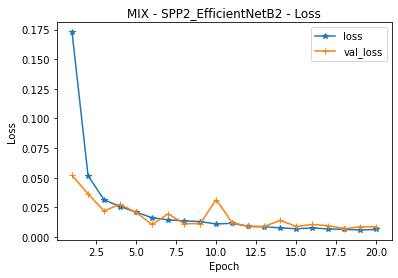

In [ ]:
import matplotlib.pyplot as plt
acc = H.history['accuracy']
val_acc = H.history['val_accuracy']
loss = H.history['loss']
val_loss = H.history['val_loss']

import matplotlib.pyplot as plt
epochs = range(1, len(acc) + 1)
plt.plot(epochs, H.history['loss'], label='loss', marker="*")
plt.plot(epochs, H.history['val_loss'], label='val_loss', marker="+")
plt.xlabel('Epoch')
plt.ylabel('Loss')
# plt.ylim([0,1])
plt.title('MIX - SPP2_EfficientNetB2 - Loss')
plt.legend()
plt.show()

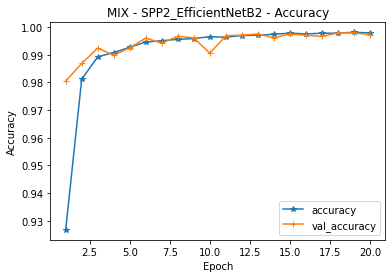

In [ ]:
plt.plot(epochs, H.history['accuracy'], label='accuracy', marker="*")
plt.plot(epochs, H.history['val_accuracy'], label='val_accuracy', marker="+")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
# plt.ylim([0,1])
plt.title('MIX - SPP2_EfficientNetB2 - Accuracy')
plt.legend()
plt.show()

**Continue_training**

In [ ]:
new_custom_callbacks = [
    EarlyStopping(
        monitor = 'val_loss',
        mode = 'min',
        patience = 5,
        verbose = 1
    ),
    ModelCheckpoint(
        filepath = os.path.join(checkpoint_filepath, 'SPP2_EfficientNetB2_CELEB_part2.h5'),
        monitor = 'val_loss',
        mode = 'min',
        verbose = 1,
        save_best_only = True
    )
]

In [ ]:
H = new_model.fit_generator(
    train_generator,
    epochs = num_epochs,
    steps_per_epoch = len(train_generator),
    validation_data = val_generator,
    validation_steps = len(val_generator),
    callbacks = new_custom_callbacks
)
print(H.history)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:7: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  import sys


Epoch 1/20
2429/2429 [==============================] - ETA: 0s - loss: 0.0057 - accuracy: 0.9980
Epoch 00001: val_loss improved from inf to 0.00700, saving model to /content/drive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB_part2.h5


/usr/local/lib/python3.7/dist-packages/keras/engine/functional.py:1410: CustomMaskWarning: Custom mask layers require a config and must override get_config. When loading, the custom mask layer must be passed to the custom_objects argument.
  layer_config = serialize_layer_fn(layer)


2429/2429 [==============================] - 827s 338ms/step - loss: 0.0057 - accuracy: 0.9980 - val_loss: 0.0070 - val_accuracy: 0.9980
Epoch 2/20
2429/2429 [==============================] - ETA: 0s - loss: 0.0060 - accuracy: 0.9979
Epoch 00002: val_loss did not improve from 0.00700
2429/2429 [==============================] - 818s 337ms/step - loss: 0.0060 - accuracy: 0.9979 - val_loss: 0.0075 - val_accuracy: 0.9977
Epoch 3/20
2429/2429 [==============================] - ETA: 0s - loss: 0.0053 - accuracy: 0.9984
Epoch 00003: val_loss did not improve from 0.00700
2429/2429 [==============================] - 816s 336ms/step - loss: 0.0053 - accuracy: 0.9984 - val_loss: 0.0230 - val_accuracy: 0.9947
Epoch 4/20
2429/2429 [==============================] - ETA: 0s - loss: 0.0050 - accuracy: 0.9984
Epoch 00004: val_loss did not improve from 0.00700
2429/2429 [==============================] - 814s 335ms/step - loss: 0.0050 - accuracy: 0.9984 - val_loss: 0.0100 - val_accuracy: 0.9970
Epoch



---



---



---



---



---



---
**Phần test**


---

---



---



---



---






In [ ]:
# !unzip /content/drive/MyDrive/DatasetFF_test.zip
!unzip /content/drive/MyDrive/DatasetCELEB_test.zip

**1) Khai báo thư viện**

In [ ]:
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator

**2) Khai báo tệp test**

In [ ]:
test_path = '/content/DatasetCELEB_test'
test_datagen = ImageDataGenerator(
    rescale = 1/255    #rescale the tensor values to [0,1]
)

test_generator = test_datagen.flow_from_directory(
    directory = test_path,
    classes=['real', 'fake'],
    target_size = (224,224),
    color_mode = "rgb",
    class_mode = None,
    batch_size = 1,
    shuffle = False
)

Found 33384 images belonging to 2 classes.


**3) Load mô hình đã học ở trên**

In [ ]:
new_model = load_model('/content/drive/MyDrive/model_checkpoint/SPP2_EfficientNetB2_CELEB_part2.h5',
                       custom_objects={'SpatialPyramidPooling2D': SpatialPyramidPooling2D})

**4) Predict tệp dataset**

In [ ]:
test_generator.reset()
preds = new_model.predict(test_generator, verbose = 1)

33384/33384 [==============================] - 551s 16ms/step


In [ ]:
print(preds)

[[4.91095462e-16 1.00000000e+00]
 [7.38362660e-09 1.00000000e+00]
 [2.26244704e-10 1.00000000e+00]
 ...
 [1.00000000e+00 1.23187610e-22]
 [1.00000000e+00 1.06842784e-16]
 [1.00000000e+00 1.25954043e-12]]


**5) Encoder True Labels (Nên kiểm tra nhãn trước, [0 1] thì set 'real, fake'**

In [ ]:
from keras.utils import np_utils
from imutils import paths
import numpy as np
import pickle
from sklearn.preprocessing import LabelEncoder
import os

path_reals = list(paths.list_images('/content/DatasetCELEB_test/real'))
labels_real = []

for path_real in path_reals:
	label2 = path_real.split(os.path.sep)[-2]
	labels_real.append(label2)
 
path_fakes = list(paths.list_images('/content/DatasetCELEB_test/fake'))
labels_fake = []

for path_fake in path_fakes:
	label3 = path_fake.split(os.path.sep)[-2]
	labels_fake.append(label3)
 
labels_test = labels_real + labels_fake

In [ ]:
print(labels_test[2])
print(labels_test[30000])

real
fake


In [ ]:
le = LabelEncoder()
labels_test = le.fit_transform(labels_test)
labels_test = np_utils.to_categorical(labels_test, 2)

f = open('le.pickle', "wb")
f.write(pickle.dumps(le))
f.close()

In [ ]:
print(labels_test[2])
print(labels_test[30000])

[0. 1.]
[1. 0.]


**6) Classification Report**

In [ ]:
from sklearn.metrics import classification_report

test = np.argmin(labels_test, axis=1)
pred = np.argmin(preds, axis=1)
print(classification_report(test, pred, target_names=le.classes_, digits = 5))

              precision    recall  f1-score   support

        fake    0.99603   0.96494   0.98024     17428
        real    0.96297   0.99580   0.97911     15956

    accuracy                        0.97969     33384
   macro avg    0.97950   0.98037   0.97968     33384
weighted avg    0.98023   0.97969   0.97970     33384



In [ ]:
print(test)
print(pred)

[0 0 0 ... 1 1 1]
[0 0 0 ... 1 1 1]


**7) Confussion Matrix**

[[16817   611]
 [   67 15889]]


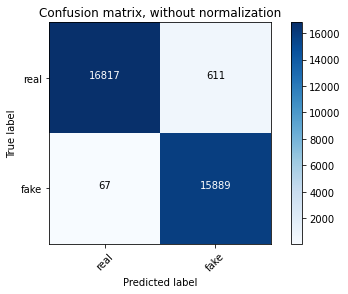

In [ ]:
from sklearn.metrics import confusion_matrix
cnf_matrix = confusion_matrix(test, pred)
print(cnf_matrix)
import matplotlib.pyplot as plt
import itertools
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1, keepdims = True)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.5f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt), horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
  
class_names = ['real', 'fake']
plt.figure()
plot_confusion_matrix(cnf_matrix, classes=class_names,
                      title='Confusion matrix, without normalization')
plt.show()

**8) EER, TPR, FPR**

In [ ]:
from sklearn.metrics import auc, roc_curve
fpr, tpr, _ = roc_curve(test, pred, pos_label=1)

fnr = 1 - tpr
fpr_eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
fnr_eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
eer = min(fpr_eer, fnr_eer)
print("tpr = ", tpr)
print("fpr = ", fpr)
print("eer = ", eer)

tpr =  [0.         0.99580095 1.        ]
fpr =  [0.         0.03505853 1.        ]
eer =  0.004199047380295862


**9) Đồ thị ROC, EER, EER_Thresh**

In [ ]:
test = np.argmin(labels_test, axis=1)
true = preds[:, 0]
print(true)

[4.9109546e-16 7.3836266e-09 2.2624470e-10 ... 1.0000000e+00 1.0000000e+00
 1.0000000e+00]


threshold at eer =  0.97734284
eer =  0.012847831536725973


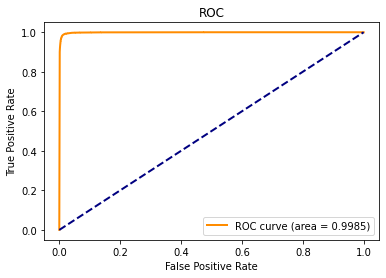

In [ ]:
from sklearn.metrics import auc, roc_curve
import matplotlib.pyplot as plt
from itertools import cycle

fpr, tpr, threshold = roc_curve(test, true, pos_label=1)
fnr = 1 - tpr
fpr_eer = fpr[np.nanargmin(np.absolute((fnr - fpr)))]
fnr_eer = fnr[np.nanargmin(np.absolute((fnr - fpr)))]
eer_threshold = threshold[np.nanargmin(np.absolute((fnr - fpr)))]
eer = min(fpr_eer, fnr_eer)
print("threshold at eer = ", eer_threshold)
print("eer = ", eer)

plt.figure()
lw = 2
plt.plot(fpr, tpr, color='darkorange',
         lw=lw, label='ROC curve (area = %0.4f)' % auc(fpr, tpr))
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC')
plt.legend(loc="lower right")
plt.show()

**10) Tính TPR 1%, TPR 0.5%, EER, EER_Threshold**

In [ ]:
import numpy as np

from scipy import interpolate

import matplotlib.pyplot as plt

from sklearn.metrics import roc_curve
from sklearn.metrics import roc_auc_score


def cal_metric(groundTruth, predicted):
    fpr, tpr, thresholds = roc_curve(groundTruth, predicted)
    y = (tpr)
    x = (fpr)
    z = tpr + fpr
    tpr = tpr.reshape((tpr.shape[0], 1))
    fpr = fpr.reshape((fpr.shape[0], 1))
    xnew = np.arange(0, 1, 0.0000001)
    func = interpolate.interp1d(x, y)
    # frr = fpr
    ynew = func(xnew)

    znew = abs(xnew + ynew - 1)

    eer = xnew[np.argmin(znew)]
    print('EER =', eer)
    # interpolate thresholds
    func_2 = interpolate.interp1d(x, thresholds)
    thresholds_new = func_2(xnew)

    print("Threshold at eer: {}".format(thresholds_new[np.argmin(znew)]))

    FPR = {"TPR(1.%)": 0.01, "TPR(.5%)": 0.005}

    TPRs = {"TPR(1.%)": 0.01, "TPR(.5%)": 0.005}

    for i, (key, value) in enumerate(FPR.items()):
        index = np.argwhere(xnew == value)

        score = ynew[index]

        TPRs[key] = float(np.squeeze(score))
    #	    print(key, score)

    auc = roc_auc_score(groundTruth, predicted)
    print('AUC = ', auc)
    print ('TPRs = ', TPRs)
    if 1:
        plt.plot(xnew, ynew)
        plt.title("ROC curve")
        plt.xlabel("FPR")
        plt.ylabel("TPR")
        plt.show()

    return eer, TPRs, auc, {'x': xnew, 'y': ynew}

EER = 0.0127726
Threshold at eer: 0.9776561970464707
AUC =  0.9985205416714876
TPRs =  {'TPR(1.%)': 0.9825144146402607, 'TPR(.5%)': 0.9616432689897217}


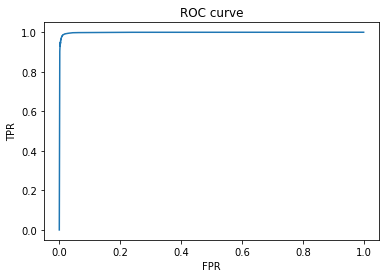

(0.0127726,
 {'TPR(.5%)': 0.9616432689897217, 'TPR(1.%)': 0.9825144146402607},
 0.9985205416714876,
 {'x': array([0.000000e+00, 1.000000e-07, 2.000000e-07, ..., 9.999997e-01,
         9.999998e-01, 9.999999e-01]),
  'y': array([0.00000000e+00, 7.28793277e-05, 1.45758655e-04, ...,
         1.00000000e+00, 1.00000000e+00, 1.00000000e+00])})

In [ ]:
cal_metric(test, true)